In [43]:
#custom Mnist style datasets (not mnist) has been loaded. To learn more on how to convert the custom dataset
#please refer the gskielians link provided in the readme.md
#the dataset has been seperated to include two classes the Number 4 and 5
#The Labels are 1 for the number 4 and 3 for the number 5

from mnist import MNIST
%matplotlib notebook

mndata = MNIST('/home/satyake/Downloads/weatherman')
mndata.gz=True

x_train, y_train = mndata.load_training()
# or
mndata1=MNIST('/home/satyake/Downloads/weatherman')
mndata1.gz=True
x_test,y_test=mndata1.load_testing()
y_train=np.array(y_train)
y_test=np.array(y_test)



AttributeError: 'list' object has no attribute 'reshape'

<IPython.core.display.Javascript object>


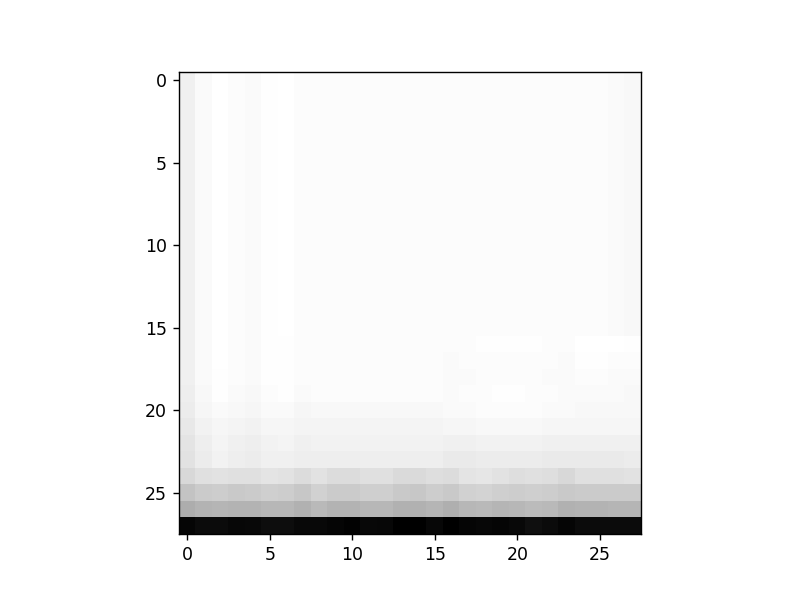

29

In [44]:
plt.imshow(np.reshape(x_train[31],(28,28)),cmap='binary')
len(x_test)
#use this command to display the array of pixels post reshapping.

In [46]:
import numpy as np 
import matplotlib.pyplot as plt
import random
from pca_plotter import PCAPlotter
import tensorflow as tf

In [47]:
def plot_triplet(data):
    plt.figure(figsize=(6,3))
    for i in range(0,3):
        plt.subplot(1,3,i+1)
        plt.imshow(np.reshape(data[i],(28,28)),cmap='gray')
    plt.show()
    
    

In [48]:
#Batch Generator
#This functin creates a batch of triplets.
def create_batch(batch_size):
    anchors=np.zeros((batch_size,784))
    positives=np.zeros((batch_size,784))
    negatives=np.zeros((batch_size,784))
    
    for i in range(0,batch_size):
            index=random.randint(0,len(x_train)-1)
            anc=x_train[index]
            label_of_anc=y_train[index]
            indices_of_pos=np.squeeze(np.where(y_train==label_of_anc))
            indices_of_neg=np.squeeze(np.where(y_train!=label_of_anc))
            #print(indices_of_pos)
            pos=x_train[indices_of_pos[random.randint(0,len(indices_of_pos)-1)]]
            neg=x_train[indices_of_neg[random.randint(0,len(indices_of_neg)-1)]]
            positives[i]=pos
            negatives[i]=neg
            anchors[i]=anc
    return [anchors,positives,negatives]

In [21]:
x_train[0]

[20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 20,
 21,
 22,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 20,
 21,
 22,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 20,
 21,
 22,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 20,
 21,
 22,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 20,
 21,
 22,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 20,
 21,
 22,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 20,
 21,
 22,
 20,
 20,
 20,
 20,


<IPython.core.display.Javascript object>


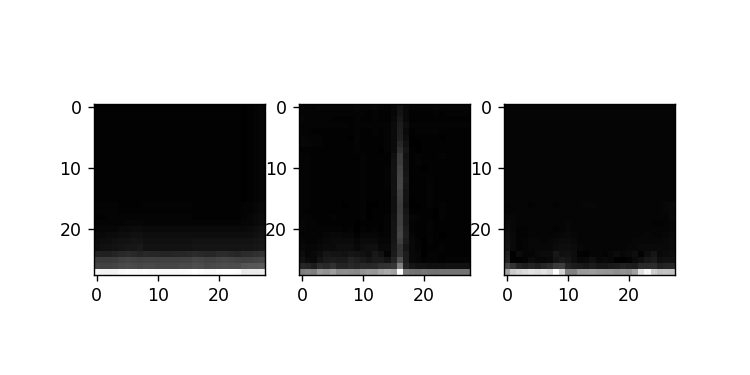

In [49]:
plot_triplet([x_train[0],x_train[1],x_train[4]])  #testing the triplet plot

<IPython.core.display.Javascript object>


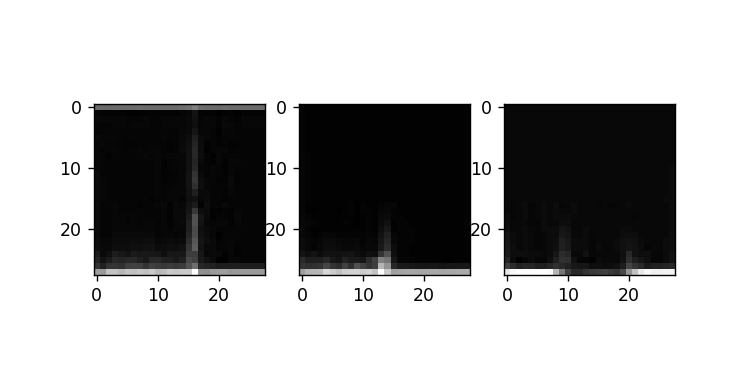

In [50]:
files=create_batch(1)
plot_triplet(files) #CHECKING THE BATCHGEN FUNCTION

In [51]:
random.randint(0,32)#Non-Essential 

2

NameError: name 'image' is not defined

In [52]:
#CREATE EMBEDDING MODEL
emb_dim=512
embedding_model=tf.keras.Sequential([tf.keras.layers.Dense(64,activation='relu',input_shape=(784,)),
                                     tf.keras.layers.Dense(512,activation='sigmoid')])

in_anc=tf.keras.layers.Input(shape=(784,))
in_pos=tf.keras.layers.Input(shape=(784,))
in_neg=tf.keras.layers.Input(shape=(784,))
emb_anc=embedding_model(in_anc) #apply the model to the anchor,positive and negatives
emb_pos=embedding_model(in_pos)
emb_neg=embedding_model(in_neg)
out=tf.keras.layers.concatenate([emb_anc,emb_pos,emb_neg],axis=1)
Network=tf.keras.models.Model([in_anc,in_pos,in_neg],out)

In [53]:
embedding_model.summary() #to view the complete model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               33280     
Total params: 83,520
Trainable params: 83,520
Non-trainable params: 0
_________________________________________________________________


In [54]:
Network.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 512)          83520       input_4[0][0]                    
                                                                 input_5[0][0]              

In [55]:
sample_embedding = embedding_model.predict(np.expand_dims(x_train[1],axis=0))[0]

print(sample_embedding) 
#testing the embedding model to see if it generates the embeddings.

[1.08320355e-01 2.09399685e-03 1.91569143e-06 7.27083310e-02
 3.50412120e-06 9.99980927e-01 1.00000000e+00 1.00000000e+00
 9.10472338e-08 9.75974500e-01 9.99989629e-01 9.99543607e-01
 1.78978186e-12 9.99993920e-01 7.89660811e-01 9.99982953e-01
 1.00000000e+00 3.32322793e-06 1.00000000e+00 3.62655520e-01
 9.98086333e-01 3.62389058e-01 9.56988394e-01 9.99996781e-01
 1.61966849e-02 5.57723222e-04 5.17218410e-08 4.05728952e-06
 9.97980773e-01 6.06539607e-01 9.99999881e-01 1.21139421e-03
 1.00000000e+00 1.00000000e+00 2.40022107e-03 9.99972820e-01
 1.90506793e-08 9.67658731e-10 8.36216331e-01 5.38156275e-09
 3.01212099e-14 9.99910474e-01 1.06176152e-03 7.91601688e-02
 1.00000000e+00 1.00000000e+00 8.13112164e-12 9.73232031e-01
 9.99702156e-01 3.22718685e-03 2.61429287e-02 7.84066913e-04
 1.00000000e+00 1.00000000e+00 9.99806345e-01 9.61188555e-01
 1.04056086e-09 1.00000000e+00 1.00000000e+00 2.93795077e-09
 4.72091883e-01 9.99999523e-01 4.95388985e-01 1.00000000e+00
 9.99993563e-01 3.544035

In [56]:
#Creation of the data_Generator
def data_generator(batch_size,emb_dim):
    while True:
        x=create_batch(batch_size)
        y=np.zeros((batch_size,3*emb_dim))
        yield x,y

In [19]:
print(data_generator(1,emb_dim))

<generator object data_generator at 0x7fb5a29569d0>


In [57]:
#Triplet Loss Function Defined
#The parameter 0.2 is the alpha,to know more please resort to the original paper.
def loss(y_true,y_pred):
        anc=y_pred[:,:emb_dim]
        pos=y_pred[:,emb_dim:2*emb_dim]
        neg=y_pred[:,2*emb_dim:]
        dp=tf.reduce_mean(tf.square(anc-pos),axis=1)
        dn=tf.reduce_mean(tf.square(anc-neg),axis=1)
        return tf.maximum(dp-dn+0.9,0.)
        

In [58]:
batch_size=1
epochs=60
steps_per_epoch=2
Network.compile(loss=loss,optimizer='rmsprop')


In [17]:
#x_test[:74]

<IPython.core.display.Javascript object>


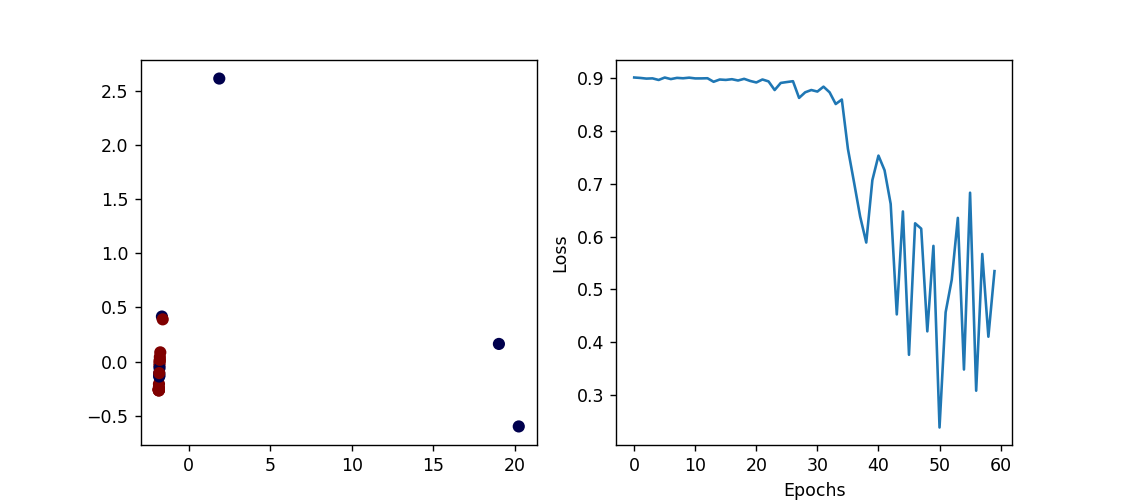

  ...
    to  
  ['...']


In [59]:
_ = Network.fit_generator(
    data_generator(batch_size,emb_dim),
    steps_per_epoch=15,
    epochs=epochs, verbose=False,
    callbacks=[
        PCAPlotter(
            plt, embedding_model,
            x_test[:26], y_test[:26]
        )]
)
#we visualize the seperation on the test_set after training

In [41]:
Network.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=60, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 30 steps
Epoch 1/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 2/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 3/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 4/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 5/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 6/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 7/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 8/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 9/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 10/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 11/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 12/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 13/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 14/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 15/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch 16/60
20/20 - 0s - loss: 0.9000 - val_loss: 0.9000
Epoch

KeyboardInterrupt: 

In [38]:
accuracy,loss=Network.evaluate(test_generator)
      

  ...
    to  
  ['...']
  79241/Unknown - 113s 1ms/step - loss: 0.9000

KeyboardInterrupt: 

In [39]:
print(accuracy)

NameError: name 'accuracy' is not defined